# Labrador Burn Scar ISP
### John Miller - ACENET Certificate in Advanced Computing 
##### Testing unsupervised (clustering) classification

In [1]:
# import libraries
import numpy as np
import geopandas as gpd

import matplotlib.pyplot as plt
import matplotlib.colors as mc

import rasterio as rio
from rasterio import plot
#from rasterio.features import shapes
from rasterio.mask import mask
from rasterio.plot import show

from shapely.geometry import mapping

from skimage import exposure, morphology
from sklearn import cluster
from sklearn import svm

from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

import warnings
#warnings.simplefilter(action = "ignore", category = RuntimeWarning)
#warnings.simplefilter(action = "ignore", category = UserWarning)
warnings.simplefilter(action = "ignore", category = FutureWarning)

In [2]:
# Open bands used in analysis

# blue band
b2 = rio.open("../Raster/T20UQC_20230922T150719_B02_20m.jp2")
# green band
b3 = rio.open("../Raster/T20UQC_20230922T150719_B03_20m.jp2")
# red band
b4 = rio.open("../Raster/T20UQC_20230922T150719_B04_20m.jp2")
# near infrared band
b8a = rio.open("../Raster/T20UQC_20230922T150719_B8A_20m.jp2")
# short wave infrared band
b12 = rio.open("../Raster/T20UQC_20230922T150719_B12_20m.jp2")
# scene classification
scl = rio.open("../Raster/T20UQC_20230922T150719_SCL_20m.jp2")

print(b2.meta)

{'driver': 'JP2OpenJPEG', 'dtype': 'uint16', 'nodata': None, 'width': 5490, 'height': 5490, 'count': 1, 'crs': CRS.from_epsg(32620), 'transform': Affine(20.0, 0.0, 699960.0,
       0.0, -20.0, 5800020.0)}


In [3]:
# Let's make a natural colour composite

# Take the metadata from one of our bands
meta = b2.meta
# Update the meta veriable so that count = 3 (3 bands)
meta.update({"count":3})

# Set out raster path
out_raster_nat = "../Raster/studyArea_naturalColour.tif"

# Write the red, green, and blue bands to the out raster
# **meta adds the metadata we saved
with rio.open(out_raster_nat, 'w', **meta) as dest:
    dest.write(b4.read(1),1)
    dest.write(b3.read(1),2)
    dest.write(b2.read(1),3)

(3, 5490, 5490)
(5490, 5490, 3)


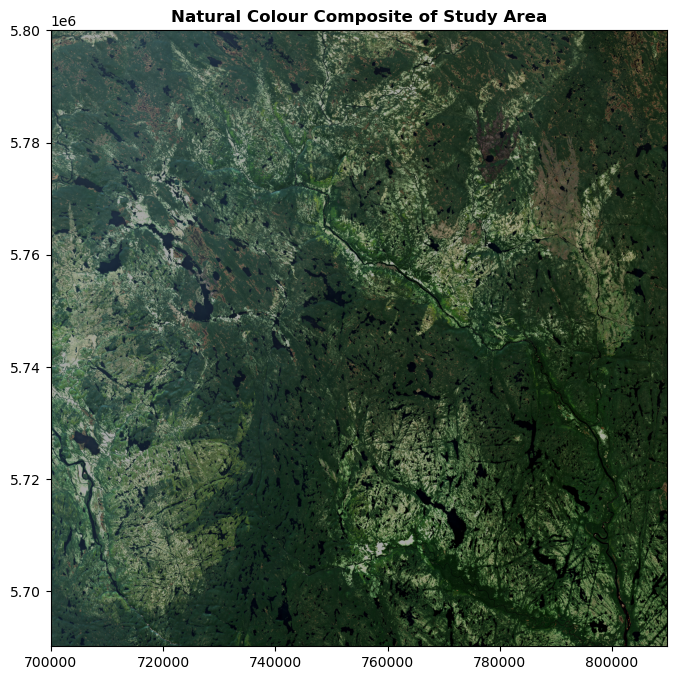

<Axes: title={'center': 'Natural Colour Composite of Study Area'}>

In [4]:
# Let's view the natural colour composite

# Open natural composite raster
natural_comp_raster = rio.open(out_raster_nat)

# Read natural composite raster as an array
natural_comp_array = natural_comp_raster.read()

# Print the shape (bands, rows, cols) to make sure it looks good
print(natural_comp_array.shape)

# Transpose the array
natural_comp_array = natural_comp_array.transpose(1,2,0)
print(natural_comp_array.shape)

# Clip the lower and upper 2 percentiles to elminate a potential contrast decrease caused by outliers
p2, p98 = np.percentile(natural_comp_array, (2,98)) 

# Use skimage to rescale the intensity. The values will range from 0 to 1
natural_comp_array = exposure.rescale_intensity(natural_comp_array, in_range=(p2, p98)) / 100000

# Define a plot
fig = plt.figure(figsize=(8,8))

# Show the natural colour composite
title = "Natural Colour Composite of Study Area"
show(natural_comp_array.transpose(2,0,1), transform=natural_comp_raster.transform, title=title)

In [5]:
# Let's make a false colour composite

# Take the metadata from one of our bands
meta = b2.meta
# Update the meta veriable so that count = 3 (3 bands)
meta.update({"count":3})

# Set out raster path
out_raster_false = "../Raster/studyArea_falseColour.tif"

# Write the shortwave infrared, infrared, and blue bands to the out raster
# **meta adds the metadata we saved
with rio.open(out_raster_false, 'w', **meta) as dest:
    dest.write(b12.read(1),1)
    dest.write(b8a.read(1),2)
    dest.write(b2.read(1),3)

(3, 5490, 5490)
(5490, 5490, 3)


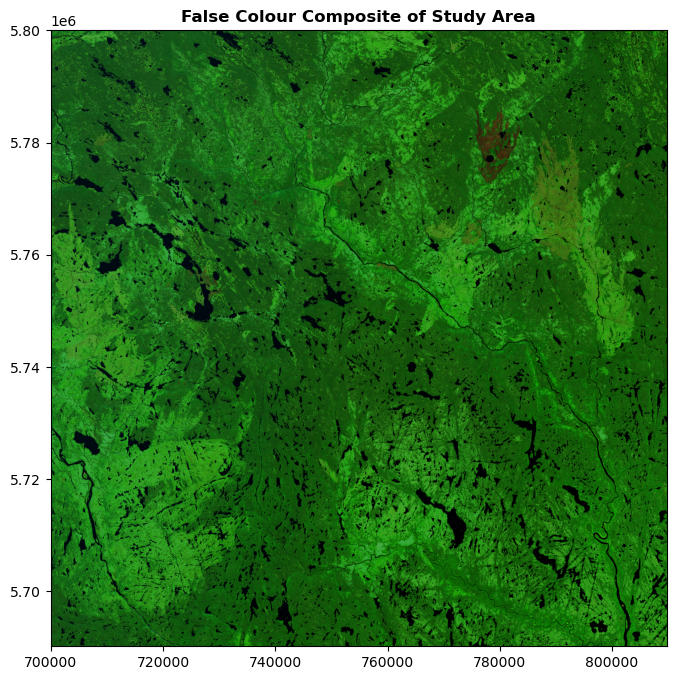

<Axes: title={'center': 'False Colour Composite of Study Area'}>

In [6]:
# Let's view the false colour composite

# Open false composite raster
false_comp_raster = rio.open(out_raster_false)

# Read false composite raster as an array
false_comp_array = false_comp_raster.read()

# Print the shape (bands, rows, cols) to make sure it looks good
print(false_comp_array.shape)

# Transpose the array
false_comp_array = false_comp_array.transpose(1,2,0)
print(false_comp_array.shape)

# Clip the lower and upper 2 percentiles to elminate a potential contrast decrease caused by outliers
p2, p98 = np.percentile(false_comp_array, (2,98)) 

# Use skimage to rescale the intensity. The values will range from 0 to 1
false_comp_array = exposure.rescale_intensity(false_comp_array, in_range=(p2, p98)) / 100000

# Define a plot
fig = plt.figure(figsize=(8,8))

# Show the false colour composite
title = "False Colour Composite of Study Area"
show(false_comp_array.transpose(2,0,1), transform=false_comp_raster.transform, title=title)

In [7]:
# Create a Normalized Burn Ratio (NBR)
# NBR = (NIR - SWIR) / (NIR + SWIR)

# Read in NIR & SWIR bands
nir = b8a.read()
swir = b12.read()

# Calculate NBR
nbr = (nir.astype(float)-swir.astype(float))/(nir+swir)

# Extract metadata from one of the bands and update
meta = b12.meta
meta.update(driver='GTiff')
meta.update(dtype=rio.float32)

# Set out raster path
out_raster_nbr = "../Raster/studyArea_NBR.tif"

# Write the NBR to the out raster
with rio.open(out_raster_nbr, 'w', **meta) as dest:
    dest.write(nbr.astype(rio.float32))

(1, 5490, 5490)


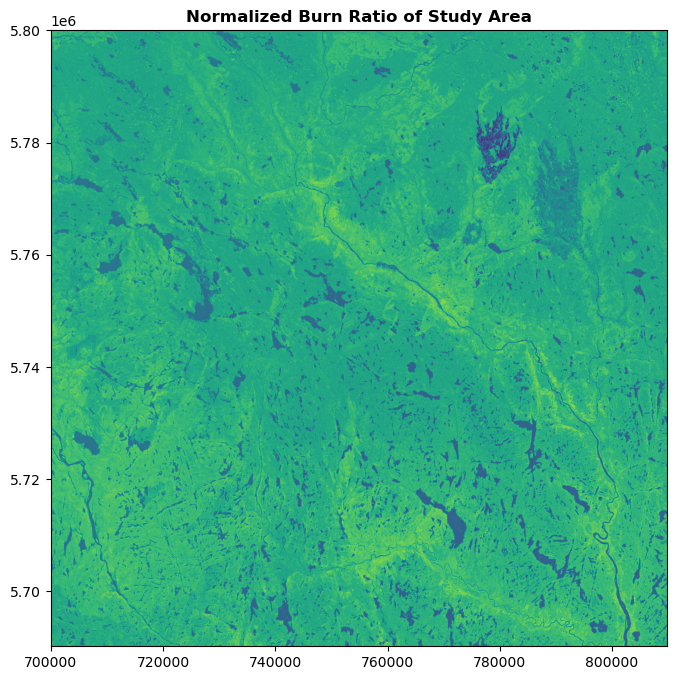

<Axes: title={'center': 'Normalized Burn Ratio of Study Area'}>

In [8]:
# Display the NBR raster
nbr_raster = rio.open(out_raster_nbr)
nbr_array = nbr_raster.read()


# Print the shape (bands, rows, cols) to make sure it looks good
print(nbr_array.shape)

# Transpose the array
#nbr_array = nbr_array.transpose(1,2,0)
#print(nbr_array.shape)

# Clip the lower and upper 2 percentiles to elminate a potential contrast decrease caused by outliers
#p2, p98 = np.percentile(nbr_array, (2,98)) 

# Use skimage to rescale the intensity. The values will range from 0 to 1
#nbr_array = exposure.rescale_intensity(nbr_array, in_range=(p2, p98)) / 100000


# Define a plot
fig = plt.figure(figsize=(8,8))

# Show the false colour composite
title = "Normalized Burn Ratio of Study Area"
#show(nbr_array.transpose(2,0,1), transform=nbr_raster.transform, title=title)
show(nbr_array, transform=nbr_raster.transform, title=title)

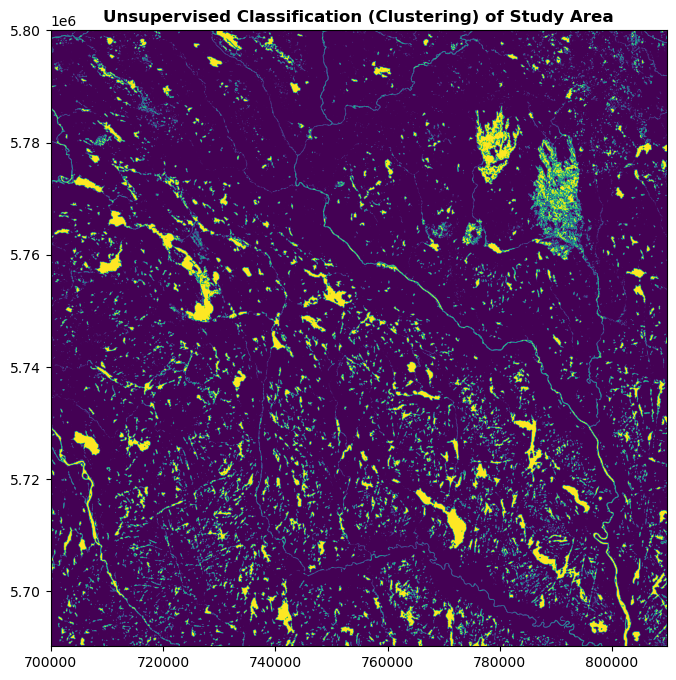

<Axes: title={'center': 'Unsupervised Classification (Clustering) of Study Area'}>

In [9]:
# Perform an unsupervised classification

# Create an empty array with the same dimensions and data type as our raster array
empty_array = np.empty((nbr_raster.height, nbr_raster.width, nbr_raster.count), nbr_raster.meta['dtype'])
#print(empty_array.shape)

# loop through the raster's bands to fill the empty array
for band in range(empty_array.shape[2]):
    empty_array[:,:,band] = nbr_raster.read(band+1)

#print(empty_array.shape)

# convet to 1d array
img1d = empty_array[:,:,:3].reshape((empty_array.shape[0]*empty_array.shape[1],empty_array.shape[2]))

#print(img1d.shape)

# create an object of the classifier and train it
cl = cluster.KMeans(n_clusters=2)
param = cl.fit(img1d)

#print(cl.labels_)

# get the labels of the classes and reshape it x-y-bands shape order (one band only)
img_cl = cl.labels_
img_cl = img_cl.reshape(empty_array[:,:,0].shape)

#print(img_cl.shape)

# Create a custom color map to represent the classes
#cmap = mc.LinearSegmentedColormap.from_list("", ["green","black"])

# Show the resulting array and save it as jpg image
plt.figure(figsize=[8,8])
#plt.imshow(img_cl, cmap=cmap)
#plt.axis('off')
#plt.show()
title = "Unsupervised Classification (Clustering) of Study Area"
show(img_cl, transform=nbr_raster.transform, title=title)

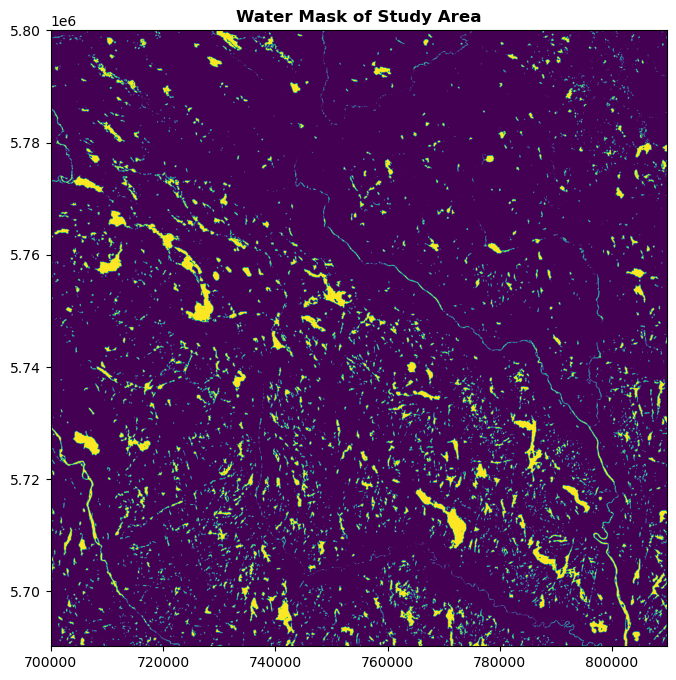

<Axes: title={'center': 'Water Mask of Study Area'}>

In [10]:
# Create a water mask
# The scl raster is a classified raster. Pixels with a value of 6 are water

# Read in the scl raster
scl_array = scl.read()

# Create a water mask by making all values != 6 equal to 0
# Converting to 0 will help when adding the water mask to the unsupervised classification
water_mask = np.where(scl_array != 6, 0, scl_array)

meta = scl.meta
meta.update(driver='GTiff')
meta.update(dtype=rio.float32)

water_path = '../Raster/studyArea_waterMask.tif'

with rio.open(water_path, 'w', **meta) as dest:
    dest.write(water_mask.astype(rio.float32))

fig = plt.figure(figsize=(8,8))
title = "Water Mask of Study Area"
show(water_mask, transform=nbr_raster.transform, title=title)

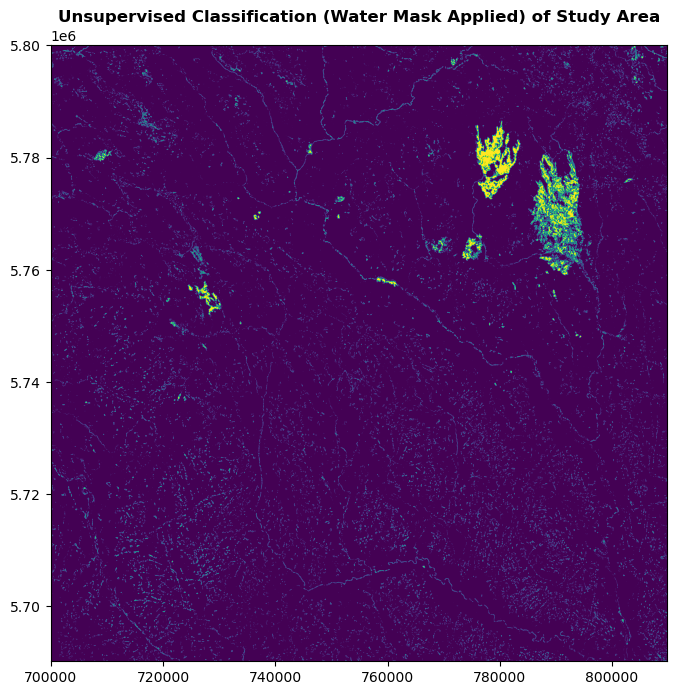

<Axes: title={'center': 'Unsupervised Classification (Water Mask Applied) of Study Area'}>

In [11]:
# Remove water from classified raster

water_raster = rio.open(water_path)
water_array = water_raster.read()

no_water = img_cl.astype(rio.float32) + water_array.astype(rio.float32)
#print(no_water)

classified_no_water = np.where(no_water > 1, 0, no_water)
#print(classified_no_water)

meta = water_raster.meta
meta.update(driver='GTiff')
meta.update(dtype=rio.float32)

unsupervised_path = '../Raster/studyArea_unsupervisedClassification.tif'

with rio.open(unsupervised_path, 'w', **meta) as dest:
    dest.write(classified_no_water.astype(rio.float32))

fig = plt.figure(figsize=(8,8))
title = "Unsupervised Classification (Water Mask Applied) of Study Area"
show(classified_no_water, transform=nbr_raster.transform, title=title)

Based on our unsupervised classification, as of Sept 22, 2023, ~10,239.88 hectares of land has been damaged by wildfires.



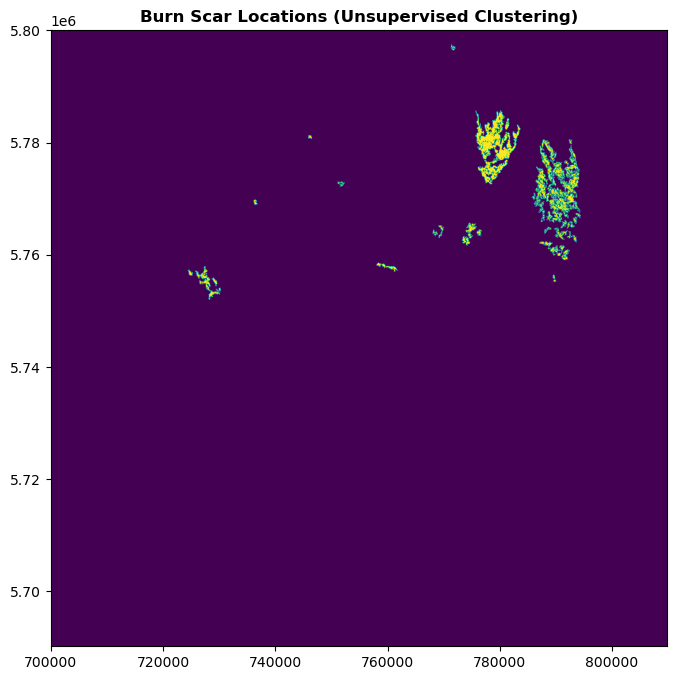

<Axes: title={'center': 'Burn Scar Locations (Unsupervised Clustering)'}>

In [12]:
# Clean the unsupervised classification by removing noise

# Read in the classified raster and convert to boolean
unsupervised_raster = rio.open(unsupervised_path)
unsupervised_array = unsupervised_raster.read().astype(bool)

# Use skimage to remove pixel clusters that are smaller in size
cleaned = morphology.remove_small_objects(unsupervised_array, min_size=600, connectivity=1)

# Get count of True pixels (pixels that are burned)
burn_pixels = np.count_nonzero(cleaned == True)

# Get total burnt area in hectares
# Number of pixels times 20x20 m pixel size divided by 10000
total_area_hect = burn_pixels * 400 / 10000

print(f"Based on our unsupervised classification, as of Sept 22, 2023, ~{total_area_hect:,.2f} hectares of land has been damaged by wildfires.\n")

meta = unsupervised_raster.meta
meta.update(driver='GTiff')
meta.update(dtype=rio.float32)

burn_scar_path = '../Raster/burnScars_unsupervisedClassification.tif'

with rio.open(burn_scar_path, 'w', **meta) as dest:
    dest.write(cleaned.astype(rio.float32))

fig = plt.figure(figsize=(8,8))
title = "Burn Scar Locations (Unsupervised Clustering)"
show(cleaned, transform=nbr_raster.transform, title=title)


In [13]:
# Bring in training data shapefile using Geopandas
training_path = "../Vector/burnScar_additionalTrainingSamples.shp"
training_data = gpd.read_file(training_path)
print(training_data.head())

  Classcode Classname  Classvalue  RED  GREEN  BLUE  Count  \
0      None  BurnScar           1    8     89    26    544   
1      None  BurnScar           1    8     89    26    546   
2      None  BurnScar           1    8     89    26    279   
3      None  BurnScar           1    8     89    26    544   
4      None  BurnScar           1    8     89    26    491   

                                            geometry  
0  POLYGON Z ((778249.972 5779649.411 0.000, 7775...  
1  POLYGON Z ((780517.208 5778461.063 0.000, 7806...  
2  POLYGON Z ((777653.809 5774470.484 0.000, 7776...  
3  POLYGON Z ((782392.811 5778812.549 0.000, 7823...  
4  POLYGON Z ((777558.741 5773939.657 0.000, 7776...  


<Axes: >

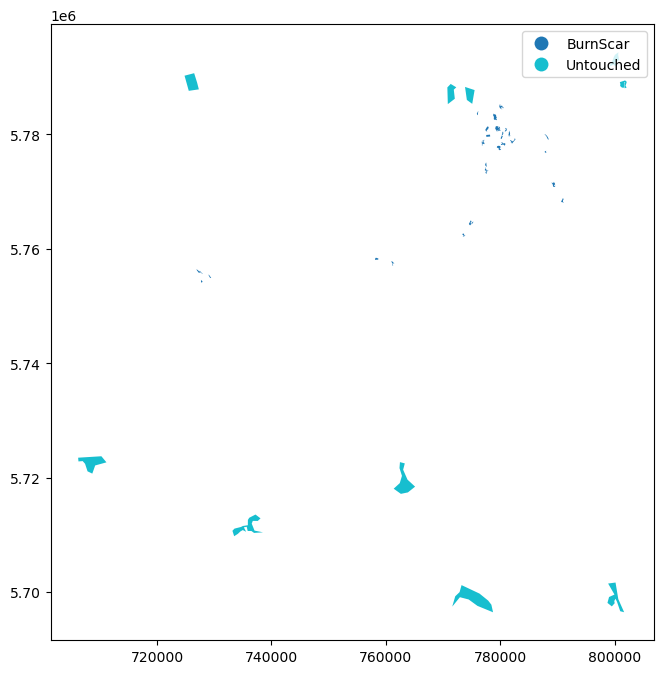

In [14]:
# Display training data
training_data.plot(column='Classname', cmap=None, legend=True, figsize=(8, 8))

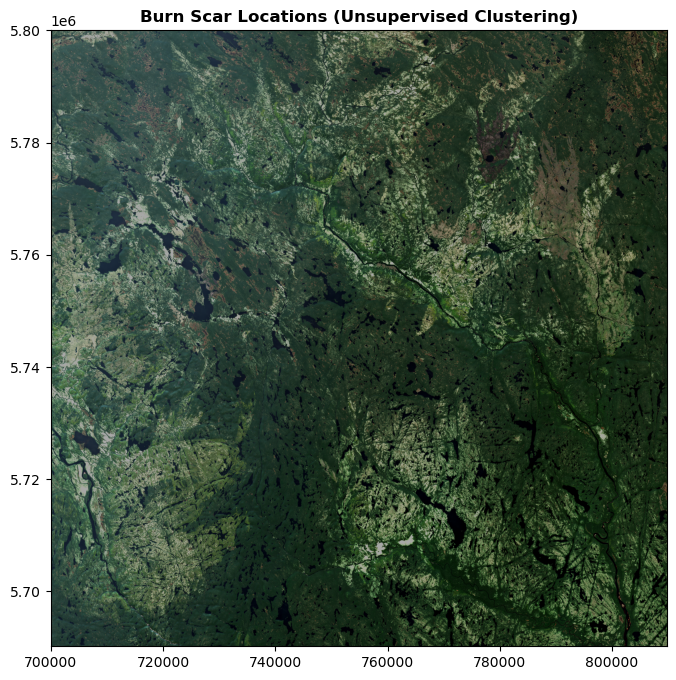

<Axes: >

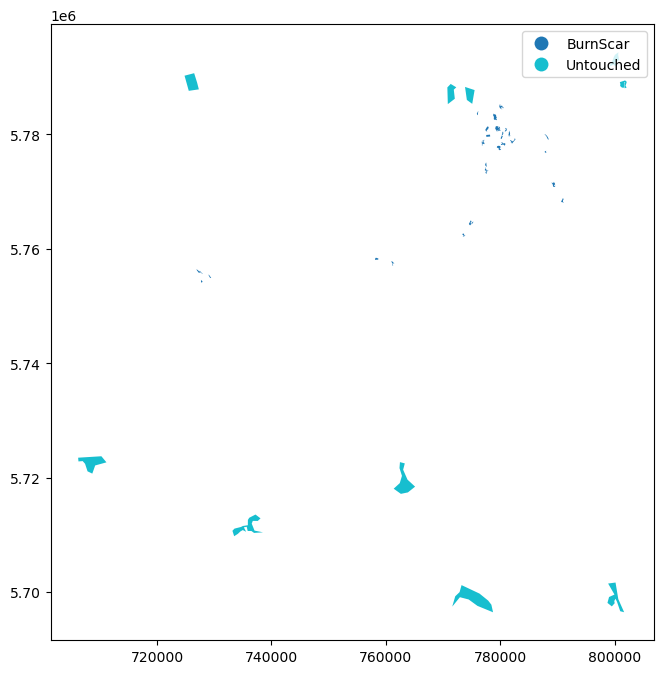

In [15]:
# Trying to show training data on NBR
fig, ax = plt.subplots(figsize=(8, 8))
show(natural_comp_array.transpose(2,0,1), transform=natural_comp_raster.transform, title=title)
training_data.plot(column='Classname', cmap=None, legend=True, figsize=(8, 8))

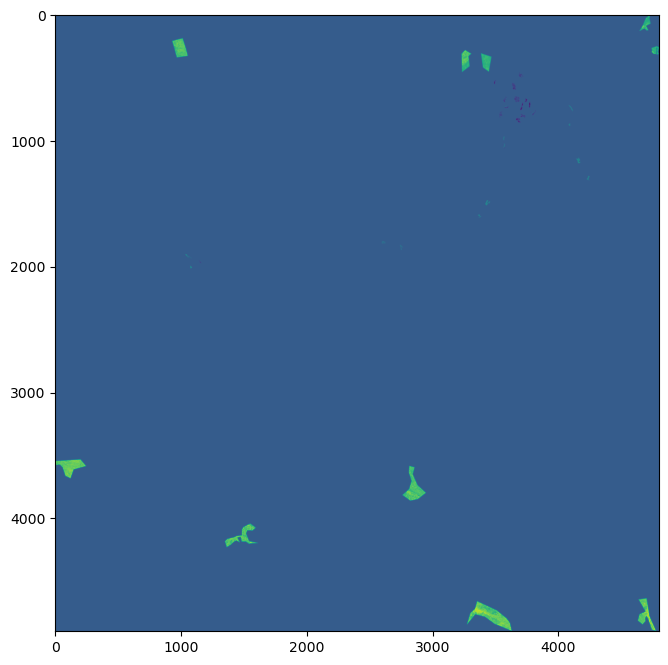

<Axes: >

In [16]:
# Extract raster values from training data using mask function
geoms = [mapping(training_data)["features"][i]["geometry"] for i in range(0,len(training_data))]

out_image, out_transform = mask(nbr_raster, geoms, crop=True)
fig, ax = plt.subplots(figsize=(8, 8))
plot.show(rio.plot.adjust_band(out_image))

In [17]:
out_image.shape

(1, 4899, 4798)

In [18]:
classes = np.unique(training_data.Classname)
classes

array(['BurnScar', 'Untouched'], dtype=object)

In [19]:
class_dict = dict(zip(classes, range(len(classes))))
class_dict   

{'BurnScar': 0, 'Untouched': 1}

In [20]:
label_pixels = np.argwhere(out_image)
print(label_pixels)

[[   0    1 4724]
 [   0    2 4723]
 [   0    2 4724]
 ...
 [   0 4897 3626]
 [   0 4897 3627]
 [   0 4897 4774]]


In [21]:
X = np.array(out_image)
X = X.reshape(X.shape[1:])
y = np.array(classes)
(X.shape, y.shape)

((4899, 4798), (2,))

In [22]:
# eliminate all the pixels with 0 values - AKA not actually part of the shapefile
out_image_trimmed = out_image[:,~np.all(out_image == 0, axis=0)]

# reshape the array to [pixel count, bands]
out_image_reshaped = out_image_trimmed.reshape(-1, 1)

X = np.array(out_image_reshaped)
X.shape

(144564, 1)

In [23]:
y = np.array([], dtype=np.string_) # labels for training

for index, geom in enumerate(geoms):
    out_image, out_transform = mask(nbr_raster, [geom], crop=True)
    # eliminate all the pixels with 0 values - AKA not actually part of the shapefile
    out_image_trimmed = out_image[:,~np.all(out_image == 0, axis=0)]

    # reshape the array to [pixel count, bands]
    out_image_reshaped = out_image_trimmed.reshape(-1, 1)
    # append the labels to the y array
    y = np.append(y,[training_data["Classname"][index]] * out_image_reshaped.shape[0])
        

print(y)

['BurnScar' 'BurnScar' 'BurnScar' ... 'BurnScar' 'BurnScar' 'BurnScar']


In [24]:
# split the data into test and train sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [25]:
X_test.shape

(28913, 1)

In [26]:
# calculate class weights to allow for training on inbalanced training samples
labels, counts = np.unique(y_train, return_counts=True)
class_weight_dict = dict(zip(labels, 1 / counts))
class_weight_dict

{'BurnScar': 9.699321047526673e-05, 'Untouched': 9.492979941333384e-06}

In [27]:
# Create SVM Classifier object  
model = svm.SVC()

# Train the model with training data and checking the score
model.fit(X_train, y_train)
model.score(X_train, y_train)

# Make predictions
predicted_values = model.predict(X_test)

In [28]:
burn_scar_path = '../Raster/burnScars_SVM.tif'

with rio.open(burn_scar_path, 'w', **meta) as dest:
    dest.write(predicted_values.astype(rio.float32))

fig = plt.figure(figsize=(8,8))
title = "Burn Scar Locations (SVM)"
show(predicted_values, transform=nbr_raster.transform, title=title)

ValueError: could not convert string to float: 'Untouched'

In [ ]:
np.unique(predicted_values)

In [ ]:
fig = plt.figure(figsize=(8,8))
show(X, transform=nbr_raster.transform)

In [ ]:
i = 0
for value in predicted_values:
    print(i)
    print(value)
    if value == 'Untouched':
        predicted_values[i] = 0
    elif value == 'BurnScar':
        predicted_values[i] = 1
    i+=1
    #print(predicted_values[i])